## Example NoiseGrad for Global Explanations

In this notebook we show how to use NoiseGrad for Global Explanation enhancement on the example of Feature Visualisations. 

• **Paper:** NoiseGrad: enhancing explanations by introducingstochasticity to model weights \\
• **Authors:** Kirill Bykov\*, Anna Hedström\*, Shinichi Nakajima, Marina M.-C. Höhne \\
• **Institution:** TU Berlin, ML Department, Understandable Machine Intelligence Lab \\
• **Date:** June, 2021 \\

*equal contribution

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.nn import Module
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm 
import time
import numpy as np
import pickle
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import copy
from torch.distributions import normal

import seaborn as sns

# Settings.
matplotlib.rcParams.update({'font.size': 15})
sns.set_theme(style="whitegrid")
sns.set()
%load_ext autoreload
%autoreload 2

plt.style.use('default')
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install torch_dreams 
import matplotlib.pyplot as plt
import torchvision.models as models
from torch_dreams.dreamer import dreamer

CLASS_NUM = 254

In [3]:
#load the model
model = torchvision.models.resnet18(pretrained=True)
posterior_mean_imgnt = copy.deepcopy(model.state_dict())

In [4]:
# generate baseline explanations

classes = [254, 130]
baselines = []

def make_baseline_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][channel_number].mean()
        return -loss
    return custom_func
dreamy_boi = dreamer(model, device = 'cuda')
layers_to_use = [model.fc]

for class_num in classes:
  my_custom_func = make_baseline_func(layer_number= 0, channel_number = class_num)

  baseline_expl = dreamy_boi.render(
      layers = layers_to_use,
      custom_func = my_custom_func,
      width = 224,
      height = 224,
      iters = 200
  )
  baselines.append(copy.deepcopy(baseline_expl)) 

100%|██████████| 200/200 [00:02<00:00, 70.14it/s]


In [5]:
#noisegrad-enhanced explanations

N_NG_INST = 100
ng_expls = []
models = {}

d = normal.Normal(loc=1, scale=.2)

#create pertrubed copies of models
for i in tqdm(range(N_NG_INST)):
  model = torchvision.models.resnet18(pretrained=True)
  with torch.no_grad():
    for param in model.parameters():
        param.mul_(d.sample(param.size()).to(param.device))
    models[str(i)] = copy.deepcopy(model)

from torch_dreams.model_bunch import ModelBunch

bunch = ModelBunch(
    model_dict = models
)


layers_to_use = [models[mdl_key].fc for mdl_key in models.keys()]
dreamy_boi = dreamer(model = bunch, quiet= False, device= 'cuda')


def custom_noisegrad_func(layer_outputs):
  out = 0.
  for loss in layer_outputs:
    out += loss[class_num]
  return -out/len(layer_outputs)

for class_num in classes:
  ng_expl = dreamy_boi.render(
      layers = layers_to_use,
      custom_func= custom_noisegrad_func,
      iters= 200,
      width = 224,
      height = 224
  )
  ng_expls.append(ng_expl)

100%|██████████| 200/200 [02:39<00:00,  1.25it/s]


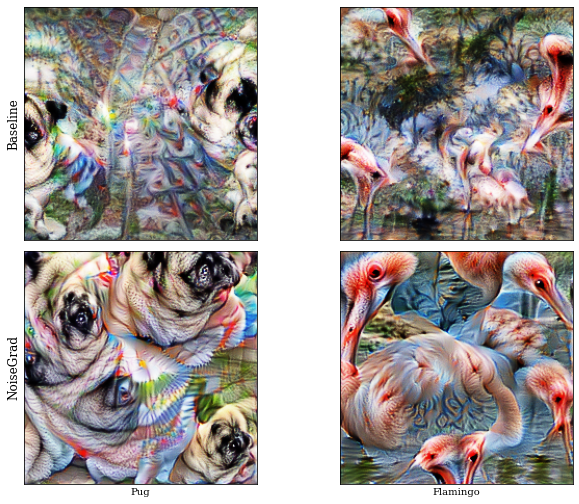

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10 , 3.55*2))
plt.rcParams["axes.grid"] = False

rows = [
        'Baseline', 
        'NoiseGrad'
        ]

cols = ["Pug",
        'Flamingo'
        ]
#rows = methods

for axe, col in zip(ax[-1], cols):
    axe.set_xlabel(col)

for axe, row in zip(ax[:,0], rows):
    axe.yaxis.set_label_position("left")
    axe.set_ylabel(row, rotation=90, size='large')

counter_1 = 0
for m in range(len(classes)):
  ax[0][m].imshow(baselines[m])
  ax[1][m].imshow(ng_expls[m])

  ax[0][m].xaxis.set_major_locator(plt.NullLocator())
  ax[0][m].yaxis.set_major_locator(plt.NullLocator())

  ax[1][m].xaxis.set_major_locator(plt.NullLocator())
  ax[1][m].yaxis.set_major_locator(plt.NullLocator())



plt.tight_layout()
plt.savefig('ng_global.png', dpi = 200)